In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import LinearScale, LogScale
from scipy import signal
from mockin import *


def plot_filter(ax1, coeffs, sample_freq, filter_name, center_freq=None, logplot=True, phase_graph=False, delay_graph=False):
    b, a = coeffs
    space = np.logspace(-2, math.log10(5),
                        1000) if logplot else np.linspace(0, 5, 1000) + 1/1000
    w, h = signal.freqz(b, a, worN=space, fs=sample_freq)
    w_bpm = 60 * w

    ax1.set_title(filter_name + ' filter characteristics')

    y1 = 20*np.log10(np.abs(h))
    if logplot:
        ax1.semilogx(w_bpm, y1, color='blue')
    else:
        ax1.plot(w_bpm, y1, color='blue')
    ax1.axhline(0, color='blue', linestyle='--')
    ax1.axhline(-3, color='blue', linestyle=':')  # -3 dB magnitude
    if center_freq:
        ax1.axvline(center_freq, color='blue',
                    linestyle=':')  # cutoff frequency
    ax1.set_xlabel('Frequency [BPM]')
    ax1.set_ylabel('Amplitude [dB]')
    ax1.margins(0, 0.1)
    ax1.grid(which='both', axis='both')

    if phase_graph:
        ax2 = ax1.twinx()
        y2 = np.angle(h)
        if logplot:
            ax2.semilogx(w_bpm, y2, color='green')
        else:
            ax2.plot(w_bpm, y2, color='green')
        ax2.axhline(0, color='green', linestyle='--')
        ax2.set_ylabel(None)
        ax2.set_yticks([])
        ax2.set_ylim(-np.pi, np.pi)
        ax2.margins(0, 0)

    if delay_graph:
        ax3 = ax1.twinx()
        phase = (2 * np.pi + np.angle(h)) % (2 * np.pi)
        y3 = 1000 * phase / (2 * np.pi * w)
        if logplot:
            ax3.semilogx(w_bpm, y3, color='orange')
        else:
            ax3.plot(w_bpm, y3, color='orange')
        ax3.axhline(0, color='orange', linestyle='--')
        ax3.set_ylim(-2, 22)
        ax3.margins(0, 0.1)
        ax3.set_ylabel('Group delay [ms]')


In [2]:
#sample_freq = input.sample_freq
sample_freq = 200

comb_q = 0.80

comb_buf_size = 64
comb_extra_buf = 8

min_detect_bpm = 83
max_detect_bpm = 200


In [3]:
dc_reject_coeffs = signal.butter(1, 0.1, fs=sample_freq, btype='highpass')
print("{ %s }," % (', '.join(map(lambda x: '%rf' % (x,), dc_reject_coeffs[0])),))
print("{ %s }" % (', '.join(map(lambda x: '%rf' % (x,), dc_reject_coeffs[1])),))


{ 0.998431665916719f, -0.998431665916719f },
{ 1.0f, -0.996863331833438f }


In [15]:
def make_comb_coeffs(q):
    def filter_periods():
        def calc_decimation(filter_period: int):
            buf_remain = comb_buf_size - comb_extra_buf
            return max(1, (filter_period + buf_remain - 1) // buf_remain)

        def next_filter_period(filter_period: int):
            decimation = calc_decimation(filter_period)
            return filter_period + decimation

        period = math.floor(sample_freq * 60 / max_detect_bpm + 0.5)
        last_distance = max_detect_bpm - min_detect_bpm
        while True:
            decimation = calc_decimation(period)
            yield (period // decimation, decimation,)
            period += decimation
            distance = abs(sample_freq * 60 / period - min_detect_bpm)
            if distance > last_distance:
                break
            last_distance = distance


    return [
        ("%.4g BPM" % (sample_freq * 60 / (period * decimation),), period, decimation,
        ([(1 - q) / decimation] * decimation,
            [1] + ([0] * (period * decimation - 1)) + [-q],))
        for period, decimation in filter_periods()
    ]

comb_coeffs = make_comb_coeffs(0.9)

# b, a = signal.butter(3, freq, fs=sample_freq, btype='highpass')


('200 BPM', 30, 2)


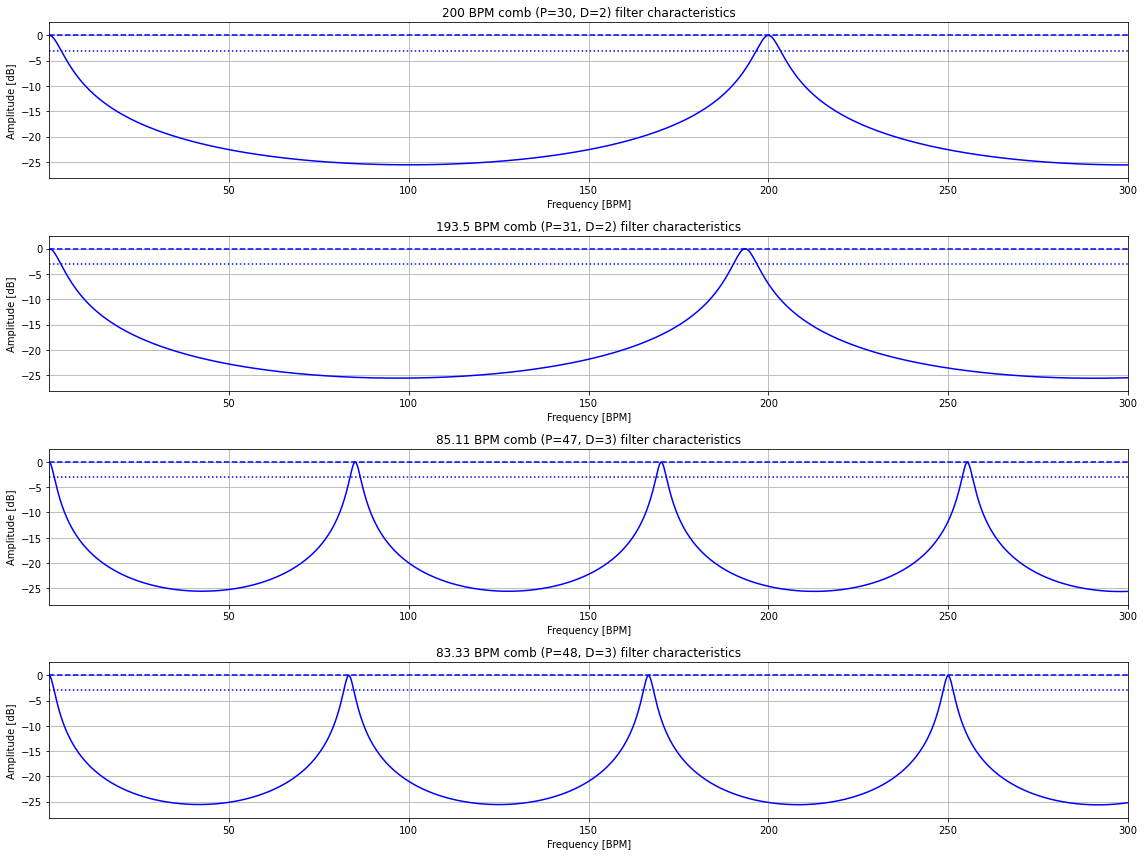

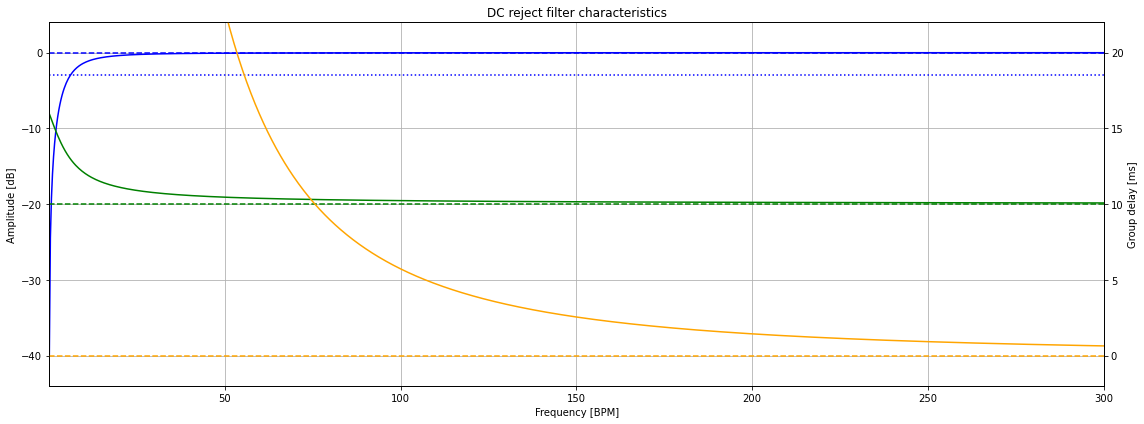

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))
print(tuple(comb_coeffs[0][0:3]))
plot_filter(ax1, comb_coeffs[0][-1], sample_freq, '%s comb (P=%g, D=%g)' % tuple(comb_coeffs[0][0:3]), logplot=False)
plot_filter(ax2, comb_coeffs[1][-1], sample_freq, '%s comb (P=%g, D=%g)' % tuple(comb_coeffs[1][0:3]), logplot=False)
plot_filter(ax3, comb_coeffs[-2][-1], sample_freq, '%s comb (P=%g, D=%g)' % tuple(comb_coeffs[-2][0:3]), logplot=False)
plot_filter(ax4, comb_coeffs[-1][-1], sample_freq, '%s comb (P=%g, D=%g)' % tuple(comb_coeffs[-1][0:3]), logplot=False)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_filter(ax, dc_reject_coeffs, sample_freq, 'DC reject', logplot=False, phase_graph=True, delay_graph=True)
fig.tight_layout()
plt.show()


In [17]:
y_148 = InputMock("sample124bpm-200hz.txt", 200, loop_count=10).read_all_samples()
y_174 = InputMock("sample174bpm-sloppy-200hz.txt", 200, loop_count=10).read_all_samples()
y_148_174 = (InputMock("sample124bpm-200hz.txt", 200, loop_count=3).read_all_samples()
    + InputMock("sample174bpm-sloppy-200hz.txt", 200, loop_count=3).read_all_samples()
    + InputMock("sample124bpm-200hz.txt", 200, loop_count=3).read_all_samples())

# y = y_148_174[17000:19000]
# plt.plot(range(len(y)), y)
# plt.show()


27093 27093


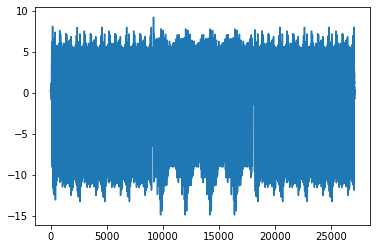

In [40]:
def dc_reject_filter(data):
    b, a = dc_reject_coeffs
    pad_len = len(dc_reject_coeffs) - 1
    pad_data = [9.8] * pad_len + data[:pad_len]
    out_data = [0] * len(data)
    for i in range(len(pad_data) - pad_len):
        y = b[0] * data[i + pad_len]
        for j in range(1, len(dc_reject_coeffs[0])):
            y += b[j] * data[i + pad_len - j] - a[j] * \
                (out_data[i - j] if j <= i else 0)
        out_data[i] = y
    for i in range(pad_len, len(data)):
        y = b[0] * data[i]
        for j in range(1, len(dc_reject_coeffs[0])):
            y += b[j] * data[i - j] - a[j] * out_data[i - j]
        out_data[i] = y
    return out_data

#y = dc_reject_filter(y_148_174)
b, a = dc_reject_coeffs
y, zf = signal.lfilter(b, a, y_148_174, zi=[9.8] * (len(a) - 1))
print(len(y_148_174), len(y))
plt.plot(range(len(y)), y)
plt.show()
